## Quickstart deduplication demo 

In this demo we de-duplicate a small dataset.

The purpose is to demonstrate core Splink functionality as succinctly as possible.

A more comprehensive example is provided [here](deduplication_detailed_example.ipynb).

## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import altair as alt
import pandas as pd

pd.options.display.max_columns = 500
alt.renderers.enable("mimetype")

RendererRegistry.enable('mimetype')

In [2]:
import logging

logging.basicConfig()  # Means logs will print in Jupyter Lab

# Set to DEBUG if you want splink to log the SQL statements it's executing under the hood
logging.getLogger("splink").setLevel(logging.INFO)

In [3]:
from utility_functions.demo_utils import get_spark

spark = get_spark()  # See utility_functions/demo_utils.py for how to set up Spark

22/01/11 05:31:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/11 05:31:45 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Step 2:  Read in data

Note that the `group` column is the truth - rows which share the same value refer to the same person.  In the real world, we wouldn't have this field!

In [4]:
df = spark.read.parquet("data/fake_1000.parquet")
df.show(5)

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|London| hannah88@powers.com|    0|
|        1|    Julia | Taylor|2015-07-31|London| hannah88@powers.com|    0|
|        2|    Julia | Taylor|2016-01-27|London| hannah88@powers.com|    0|
|        3|    Julia | Taylor|2015-10-29|  null|  hannah88opowersc@m|    0|
|        4|      oNah| Watson|2008-03-23|Bolton|matthew78@ballard...|    1|
+---------+----------+-------+----------+------+--------------------+-----+
only showing top 5 rows



## Step 3:  Configure splink using the `settings` object

Most of `splink` configuration options are stored in a settings dictionary.  This dictionary allows significant customisation, and can therefore get quite complex.  

✅ We provide an tool for helping to author valid settings dictionaries, which includes tooltips and autocomplete, which you can find 👉 [here](http://robinlinacre.com/splink_settings_editor/) 👈.

If no customisation is used, Splink will use sensible defaults.

In [5]:
settings = {
    "link_type": "dedupe_only",
    "blocking_rules": ["l.surname = r.surname"],
    "comparison_columns": [
        {"col_name": "first_name", "num_levels": 3, "term_frequency_adjustments": True},
        {"col_name": "dob"},
        {"col_name": "city"},
        {"col_name": "email"},
    ],
    "additional_columns_to_retain": ["group"],
    "em_convergence": 0.01,
    "max_iterations": 4,
}

In words, this setting dictionary says:
- We are performing a deduplication task (the other options are `link_only`, or `link_and_dedupe`)
- The blocking rule states that we will all possibly record comparisons where the surname is equal.
- When comparing records, we will use information from the `first_name`, `dob`, `city` and `email` columns to compute a match score.
- For `first_name` string comparisons will have three levels:
    - Level 2: Strings are exactly the same
    - Level 1: Strings are similar 
    - Level 0: No match
- We will make adjustments for term frequencies on the `first_name` columns
- We will retain the `group` column in the results even though this is not used as part of comparisons.  This is a labelled dataset and `group` contains the true match - i.e. where group matches, the records pertain to the same person
- Will will consider the algorithm to have converged when no parameter changes by more than 0.01 between iterations or four iterations.  (Generally we would allow more than four, but this makes the demo run more quickly).

## Step 4:  Estimate match scores using the Expectation Maximisation algorithm
Columns are assumed to be strings by default.  See the 'comparison vector settings' notebook for details of configuration options.

In [6]:
from splink import Splink

linker = Splink(settings, df, spark)
df_e = linker.get_scored_comparisons()

INFO:splink.iterate:Iteration 0 complete                                        
INFO:splink.model:The maximum change in parameters was 0.22152794522277064 for key first_name, level 0
INFO:splink.iterate:Iteration 1 complete
INFO:splink.model:The maximum change in parameters was 0.05266340978811679 for key city, level 1
INFO:splink.iterate:Iteration 2 complete
INFO:splink.model:The maximum change in parameters was 0.0244506360130074 for key email, level 0
INFO:splink.iterate:Iteration 3 complete
INFO:splink.model:The maximum change in parameters was 0.01397596095506537 for key email, level 1


## Step 5: Inspect results 



In [7]:
cols_to_inspect = ["match_probability", "match_weight", "unique_id_l", "unique_id_r", "group_l", "group_r", "first_name_l", "first_name_r", "dob_l", "dob_r", "city_l", "city_r", "email_l", "email_r"]

df_e.toPandas()[cols_to_inspect].sort_values(["unique_id_l", "unique_id_r"]).head(5)

,match_probability,match_weight,unique_id_l,unique_id_r,group_l,group_r,first_name_l,first_name_r,dob_l,dob_r,city_l,city_r,email_l,email_r
548,0.999952,14.345731,1,2,0,0,Julia,Julia,2015-07-31,2016-01-27,London,London,hannah88@powers.com,hannah88@powers.com
549,0.895912,3.105561,1,3,0,0,Julia,Julia,2015-07-31,2015-10-29,London,None,hannah88@powers.com,hannah88opowersc@m
550,0.036397,-4.726541,1,89,0,18,Julia,Chirla,2015-07-31,2006-06-28,London,London,hannah88@powers.com,mbrooks@booker.com
551,0.036397,-4.726541,1,142,0,26,Julia,Harry,2015-07-31,2017-11-24,London,London,hannah88@powers.com,coltonray@lee.com
552,0.036397,-4.726541,1,148,0,26,Julia,Harry,2015-07-31,2017-09-01,London,London,hannah88@powers.com,coltonray@lee.com


The `model` property of the `linker` is an object that contains a lot of diagnostic information about how the match probability was computed.  The following cells demonstrate some of its functionality

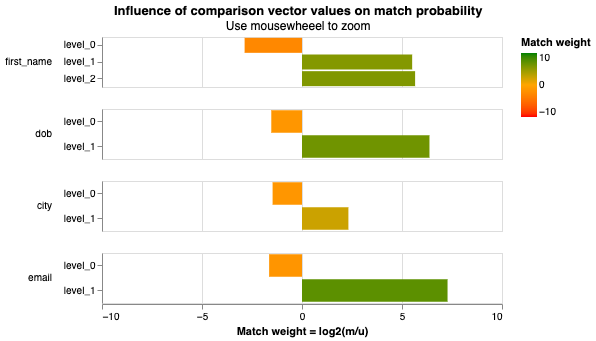

In [8]:
model = linker.model
model.bayes_factor_chart()

If charts aren't displaying correctly in your notebook, you can write them to an file, and view them in an IFrame.

In [9]:
from splink.charts import save_offline_chart

chart = model.bayes_factor_chart()
save_offline_chart(chart, filename="bf.html", overwrite=True)

Chart saved to bf.html

To view in Jupyter you can use the following command:

from IPython.display import IFrame
IFrame(src="./bf.html", width=1000, height=500)



You can also output a dashboard of the main charts:

In [10]:
model.all_charts_write_html_file(filename="splink_charts.html", overwrite=True)

# Use graphframes to resolve links into groups

Finally, we can turn the pairwise record comparisons into estimated groups (clusters of records considered to be the same).

You must provide one or more cluster thresholds, which is the match probability above which a pairwise comparison is considered a match

In [11]:
from splink.cluster import clusters_at_thresholds

thresholds = {"cluster_0_5": 0.5, "cluster_0_9": 0.9}
clusters_at_thresholds(df, df_e, thresholds, linker.model).toPandas()

,cluster_0_5,cluster_0_9,unique_id,first_name,surname,dob,city,email,group
0,1,1,2,Julia,Taylor,2016-01-27,London,hannah88@powers.com,0
1,12,12,12,Noah,None,2008-03-23,Blotn,None,1
2,23,23,26,Ollie,Thompson,1996-03-22,Leeds,jefferyduke@brown-alazar.org,5
3,28,28,28,Matilda,None,1983-04-30,London,patricia47@davis.com,6
4,29,29,29,Harris,Matilda,1983-04-30,London,patricia47@davis.com,6
...,...,...,...,...,...,...,...,...,...
995,947,947,951,Ael ai,Johnson,1985-05-04,Luton,oleondanisle@martinez.com,170
996,963,963,963,Gabriel,Bartltt,1973-12-09,Wolverhampton,ogomez@robinson-mckinney.com,173
997,971,971,971,None,Taylor,1978-05-09,Ldnon,tiffanyrodriguez@rodriguez-yu.com,175
998,977,977,980,Layla,Ball,1992-04-02,Newcastle-upon-Tyne,stacykelly@brown.info,176
